# Game2Mov

The boundaries between the movie industry and the games industry are becoming increasingly blurred; and the techniques of computer graphics and generative computer vision are converging at the same time.

For this coursework, you will take advantage of these shifts by attempting to make video games more “movie-like”. The base dataset consists of .mp4 movie files from the 2002 video-game Mafia, and from famous mobster movies/shows: The Godfather (1-3), The Sopranos, and The Irishman

**This notebook was built for execution with Google Colab**

# PIP, Imports & Initialisations

In [ ]:
!pip install dlib pytorch-lightning comet-ml

# priority imports
import comet_ml
from pytorch_lightning.loggers import CometLogger

# imports
import cv2
import dlib
from google.colab import drive
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from PIL import Image
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils import data
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

# reproducability
SEED = 97
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

clear_output(wait=False)


# Preprocessing

In [ ]:
#@markdown This block assumes that all the video files are in the original game/movie split in a Google Drive directory.

#@markdown Path (relative to the root of your Google Drive) to the game/movie directories.
INPUT_FILEPATH = "game2mov" #@param{type:"string"}


In [ ]:
domains = ['game', 'movie']
drive.mount('/content/drive/')


try:
    # Frames are pickled locally once already processed once.
    pfx = f'/content/drive/My Drive/{INPUT_FILEPATH}/'
    with open(pfx + 'scenes.pkl', 'rb') as scene_file:
        scene_frames = pickle.load(scene_file)
    
    with open(pfx + 'faces.pkl', 'rb') as face_file:
        face_frames = pickle.load(face_file)

except FileNotFoundError:

    dis = display(None, display_id=True)
    face_detector = dlib.get_frontal_face_detector()

    NUM_FRAMES = 1000
    FACE_RESOLUTION = 128, 128
    scene_frames = {key: np.zeros(shape=[NUM_FRAMES, 720, 1280, 3],
                                  dtype=np.uint8) for key in domains}
    face_frames = {key: np.zeros(shape=[NUM_FRAMES, *FACE_RESOLUTION, 3],
                                 dtype=np.uint8) for key in domains}

    for domain in domains:
        dir = f'/content/drive/My Drive/{INPUT_FILEPATH}/{domain}/'
        videos = os.listdir(dir)
        frames_per_vid = NUM_FRAMES // len(videos)
        scene_count = 0
        face_count = 0

        for name in videos:
            video = cv2.VideoCapture(dir + name)
            total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

            sample_freq = total_frames // (frames_per_vid)
            sample_idxs = range(sample_freq * 3, total_frames-sample_freq, sample_freq)
            print(f'Trialling {len(list(sample_idxs))} frames from {name}')

            for frame_idx in tqdm(sample_idxs):
                video.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)   # move to frame
                valid, frame = video.read()
                if not valid:
                    break
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = np.array(frame)
                faces, scores, _ = face_detector.run(frame, 1, -1)
                if len(scores) > 0 and max(scores) > 0.5:
                    # filter frames to only fames which have something like face in
                    scene_frames[domain][scene_count] = frame               
                    scene_count += 1
                    faces = [face for (face, score) in zip(faces, scores)
                                                            if score > 0.5]
                    for face in faces:
                        longest_edge = max(face.width(), face.height())
                        center = face.dcenter()
                        x, y = center.x, center.y
                        face_crop = frame[y - longest_edge//2:y + longest_edge//2,
                                        x - longest_edge//2:x + longest_edge//2]
                        try:
                            
                            face_frame = cv2.resize(face_crop, FACE_RESOLUTION,
                                                        interpolation=cv2.INTER_AREA)
                            face_frames[domain][face_count] = face_frame
                            face_count += 1
                        except:
                            ''' if the face is on the edge of a frame the square
                            expansion can go outside of frame. In this case just skip
                            it - there are enough faces in the set already'''
                            continue
            
                    dis.update(Image.fromarray(face_frame))   
            
            video.release()

        scene_frames[domain] = scene_frames[domain][:scene_count]
        print(f'Collected {len(scene_frames[domain])} scene frames in the {domain} domain.')
        face_frames[domain] = face_frames[domain][:face_count]
        print(f'Collected {len(face_frames[domain])} faces in the {domain} domain.')

    with open('/content/scenes.pkl', 'wb') as scene_file:
        pickle.dump(scene_frames, scene_file, protocol=pickle.HIGHEST_PROTOCOL)

    with open('/content/faces.pkl', 'wb') as face_file:
        pickle.dump(face_frames, face_file, protocol=pickle.HIGHEST_PROTOCOL)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Train/Val/Test Split

Data is split for both frames and faces. The first 70% is allocated to the training dataset, the next 20% is for validation and the final 10% is assigned to the test dataset. The split is deterministic, preserving the original order of the video, such that frames from the same scene are not present in multiple splits.

In [ ]:
CUM_SPLIT_RATIO = 0, 0.7, 0.9, 1
for idx, dataset in enumerate([scene_frames, face_frames]):
    split = {}
    for domain in domains:
        domain_data = dataset[domain]
        size = len(domain_data)
        split_idxs = [int(size*factor) for factor in CUM_SPLIT_RATIO]
        split[domain] = [domain_data[split_idxs[i]:split_idxs[i+1]]
                         for i in range(len(CUM_SPLIT_RATIO) - 1)]
         
    if idx == 0:
        split_scenes = split
    else:
        split_faces = split


## Define Data Handler Classes

Loosely based on this [kaggle](https://www.kaggle.com/bootiu/cyclegan-pytorch-lightning)

In [ ]:
class ImageTransformer:
    def __init__(self, scale=1, resolution=(1280,720), augment=False):
        new_res = [int(x * scale) for x in resolution]
        transform_list = [
                        transforms.Resize(new_res),
                        transforms.ToTensor(),
                        # normalise for tanhing
                        transforms.Normalize(mean=[0.5], std=[0.5])
        ]


        if augment:
            up_res = [int(x * 1.1) for x in new_res]
            transform_list.extend([
                transforms.Resize(up_res),
                transforms.RandomCrop(new_res),
                transforms.RandomHorizontalFlip()
            ])

        self.transform = transforms.Compose(transform_list)
        
    

    def __call__(self, img):
        img = self.transform(img)
        return img

In [ ]:
class Game2MovDataset(data.Dataset):
    def __init__(self, game_imgs, movie_imgs, transform):
        self.game = game_imgs
        self.movie = movie_imgs
        self.transform = transform

    
    def __len__(self):
        return min(len(self.game), len(self.movie))
    

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        game_img = Image.fromarray(self.game[idx])
        movie_img = Image.fromarray(self.movie[idx])
        game_img = self.transform(game_img)
        movie_img = self.transform(movie_img)
        return game_img, movie_img


In [ ]:
class Game2MovDataModule(pl.LightningDataModule):
    def __init__(self, data, transform, batch_size):
        super(Game2MovDataModule, self).__init__()
        self.game = data['game']
        self.movie = data['movie']
        self.transform = transform
        self.batch_size = batch_size

    
    def train_dataloader(self):
        self.train_dataset = Game2MovDataset(self.game[0], self.movie[0], 
                                             self.transform)
        return data.DataLoader(self.train_dataset, batch_size=self.batch_size,
                               num_workers=2, shuffle=True, pin_memory=True)
    

    def val_dataloader(self):
        self.val_dataset = Game2MovDataset(self.game[1], self.movie[1], 
                                           self.transform)
        return data.DataLoader(self.val_dataset, batch_size=1, num_workers=2,
                               shuffle=False, pin_memory=True)


    def test_dataloader(self):
        self.test_dataset = Game2MovDataset(self.game[2], self.movie[2], 
                                           self.transform)
        return data.DataLoader(self.val_dataset, batch_size=self.batch_size,
                               num_workers=2, shuffle=False, pin_memory=True)


## Sanity Check

Game shape torch.Size([16, 3, 720, 720])     Movie shape torch.Size([16, 3, 720, 720])


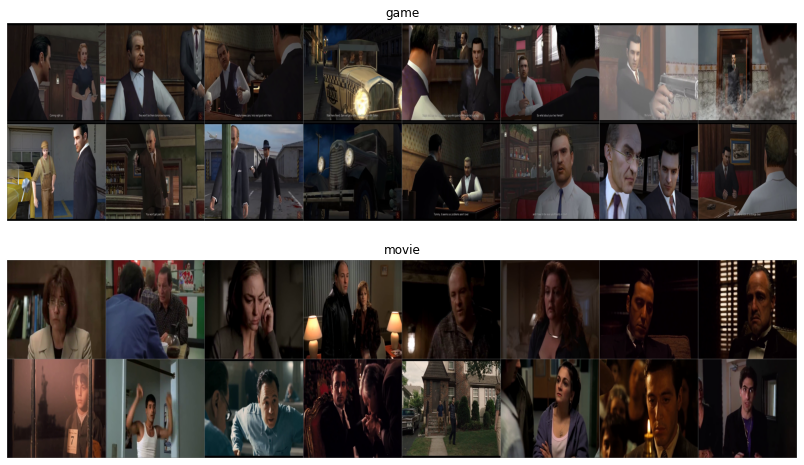

In [ ]:
transformer = ImageTransformer(scale=2**-0, resolution=[720,720])
batch_size = 16

data_module = Game2MovDataModule(split_scenes, transformer, batch_size)
dataloader = data_module.train_dataloader()

game, movie = next(iter(dataloader))

print(f'Game shape {game.shape}     Movie shape {movie.shape}')

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(24, 8)
fig.set_facecolor('white')
grids = [make_grid(x, nrow=8, padding=2).permute(1, 2, 0).detach().numpy()
         for x in [game, movie]]
grids = [((grid * 0.5 + 0.5) * 255).astype(int) for grid in grids]

for ax, grid, label in zip(axs, grids, domains):
    ax.imshow(grid)
    ax.set_title(label)
    ax.set_axis_off()


# Attention Cycle-GAN

## Model Definition

Broadly based on [PyTorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )
    
    
    def forward(self, x):
        return x + self.block(x)

Based on [Tang Et Al., 2019.](https://arxiv.org/abs/1903.12296)

In [ ]:
class Generator(nn.Module):
    def __init__(self, shape):
        super(Generator, self).__init__()
        channels = shape[1]
        features = 64

        self.preprocess = nn.Sequential(
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, features, 7),
            nn.InstanceNorm2d(features),
            nn.ReLU(True)
        )

        down_layers = []
        for _ in range(2):
            features *= 2
            down_layers.extend([
                nn.Conv2d(features//2, features, 3, 2, 1, 1),
                nn.InstanceNorm2d(features),
                nn.ReLU(True)
            ])
        self.downsample = nn.Sequential(*down_layers)
        
        self.res_block = nn.Sequential(*[ResidualBlock(features) for _ in range(6)])

        up_layers = []
        for _ in range(2):
            features //= 2
            up_layers.extend([
                nn.ReflectionPad2d(1),                              
                nn.Conv2d(features*2, features, 3, 1, 0),
                nn.InstanceNorm2d(features),
                nn.ReLU(True),
                nn.Conv2d(features, features*4, 1, 1, 0),
                nn.PixelShuffle(2),
                nn.InstanceNorm2d(features),
                nn.ReLU()
            ])
        self.upsample = nn.Sequential(*up_layers)
        
        self.output = nn.Sequential(
            nn.ReflectionPad2d(channels),
            nn.Conv2d(features, 4, 7)
        )
    

    def forward(self, x):
        out = self.preprocess(x)
        out = self.downsample(out)
        out = self.res_block(out)
        out = self.upsample(out)
        out = self.output(out)

        
        attention = torch.tanh(out[:, 0]).repeat(1, 3, 1, 1)
        content = torch.tanh(out[:, 1:])
        result = content * attention + x * (1 - attention)
        return result, attention, content
           

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, shape):
        super(Discriminator, self).__init__()
        batch_size, channels, height, width = shape
        self.shape_out = (1, height // 2**4, width // 2**4)

        def discriminator_block(in_filters, out_filters):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1),
                      nn.InstanceNorm2d(out_filters),
                      nn.LeakyReLU(0.2, inplace=True)]
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Conv2d(512, 512, 4),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(512, 1, 1)
        )

    def forward(self, img):
        return self.model(img) 


## Lightning System

I use pytorch-lightning to handle logging and looper boilerplate

In [ ]:
class LightningSystem(pl.LightningModule):
    def __init__(self, shape, lr):
        super(LightningSystem, self).__init__()
        self.game_to_movie = Generator(shape)
        self.movie_to_game = Generator(shape)
        self.D_game = Discriminator(shape)
        self.D_movie = Discriminator(shape)
        self.lr = lr

        self.l1 = nn.L1Loss()
        self.l2 = nn.MSELoss()

        self.epoch = 0 
        self.min_game_loss = float('inf')
        self.min_movie_loss = float('inf')
        self.best_game = None
        self.best_movie = None



    def configure_optimizers(self):
        G_game_optim = torch.optim.Adam(self.game_to_movie.parameters(), lr=self.lr['G'])
        G_movie_optim = torch.optim.Adam(self.movie_to_game.parameters(), lr=self.lr['G'])
        D_game_optim = torch.optim.Adam(self.D_game.parameters(), lr=self.lr['D'])
        D_movie_optim = torch.optim.Adam(self.D_movie.parameters(), lr=self.lr['D'])
        
        return [G_game_optim, G_movie_optim, D_game_optim, D_movie_optim]

    
    def training_step(self, batch, batch_idx, optimizer_idx):
        game, movie = batch

        batch_size = game.shape[0]
        real = torch.ones([batch_size, 1, 1, 1]).cuda()
        fake = torch.zeros([batch_size, 1, 1, 1]).cuda()

        if optimizer_idx < 2: 
            game_pred, game_mask, game_raw = self.movie_to_game(movie)
            movie_pred, movie_mask, movie_rasw = self.game_to_movie(game)

            val_game = self.l2(self.D_game(game_pred), real)
            val_movie = self.l2(self.D_movie(movie_pred), real)
            val_loss = (val_game + val_movie) / 2

            recon_game = self.l1(self.movie_to_game(movie_pred)[0], game)
            recon_movie = self.l1(self.game_to_movie(game_pred)[0], movie)
            recon_loss = (recon_game + recon_movie) / 2

            id_game = self.l1(movie_pred, game)
            id_movie = self.l1(game_pred, movie)
            id_loss = (id_game + id_movie) / 2
   

            loss = 1*val_loss + 2*recon_loss + 0.5*id_loss
            self.log(f'gen_{optimizer_idx}_loss', loss)

            return {'loss': loss, 'val_loss': val_loss,
                    'recon_loss': recon_loss, 'id_loss': id_loss}

        else:
            game_fake = self.l2(self.D_game(self.movie_to_game(movie)[0]), fake)
            movie_fake = self.l2(self.D_movie(self.game_to_movie(game)[0]), fake)

            game_real = self.l2(self.D_game(game), real)
            movie_real = self.l2(self.D_movie(movie), real)

            fake_loss = (game_fake + movie_fake) / 2
            
            loss = (fake_loss + game_real + movie_real) / 3
            self.log(f'gen_{optimizer_idx}_loss', loss)


            return {'loss': loss}

    
    def validation_step(self, batch, batch_idx):
        game, movie = batch

        movie_pred, attn, _ = self.game_to_movie(game)
        recon_loss = self.l1(self.movie_to_game(movie_pred)[0], game)
        if recon_loss < self.min_game_loss:
            self.min_game_loss = recon_loss
            self.best_game = [game, movie_pred, attn[:, 0, :, :]]
        
        game_pred, attn, _ = self.movie_to_game(movie)
        recon_loss = self.l1(self.game_to_movie(game_pred)[0], movie)
        if recon_loss < self.min_movie_loss:
            self.min_movie_loss = recon_loss
            self.best_movie = [movie, game_pred, attn[:, 0, :, :]]


    def validation_epoch_end(self, outputs):
        epoch_str = f'Epoch {self.epoch}: '
        sfxs = ['Original Game', 'Movie-styled', 'Game Attention',
                'Original Movie', 'Game-styled', 'Movie Attention']

        for img, sfx in zip(self.best_game + self.best_movie, sfxs):
            self.log_image(img, epoch_str + sfx)
        
        self.epoch += 1


    def log_image(self, img, label):
        # undo normalisation
        img = img * 0.5 + 0.5
        img = img * 255
        img = img.cpu().squeeze(0)
        self.logger.experiment.log_image(img, name=label, image_channels='first')
    
    
    def test_step(self, batch, batch_idx):
        game, movie = batch
        movie_pred, movie_attn, _ = self.game_to_movie(game)
        game_pred, game_attn, _ = self.movie_to_game(movie)

        imgs = [game, movie_pred, movie_attn, movie, game_pred, game_attn]
        batch_str = f'{batch_idx}: '
        sfxs = ['Original Game', 'Movie-styled', 'Game Attention',
                'Original Movie', 'Game-styled', 'Movie Attention']

        for img, sfx in zip(imgs, sfxs):
            self.log_image(img, batch_str + sfx)


# Training loop

In [ ]:
learning_rates = {'G': 2e-3, 'D': 2e-4}
transformer = ImageTransformer(scale=2**-0, resolution=[128,128])
data_module = Game2MovDataModule(split_scenes, transformer, 1)
shape = game.shape
model = LightningSystem(shape, learning_rates)

logger = CometLogger(
    api_key='zec9nIWkkarCcQbsME2CwpqWT',
    workspace=os.environ.get('guymccombe'),
    project_name='game2movie',
    experiment_name='Attention CycleGAN'
)

trainer = pl.Trainer(
    logger=logger,
    max_epochs = 20,
    gpus=1,
    reload_dataloaders_every_epoch=False,
)

trainer.fit(model, datamodule=data_module)
trainer.test()


# Augmented Data Training

In [ ]:
learning_rates = {'G': 2e-3, 'D': 2e-4}
augment_transformer = ImageTransformer(resolution=(128,128), augment=True)
data_module = Game2MovDataModule(split_faces, augment_transformer, 1)
shape = game.shape
model = LightningSystem(shape, learning_rates)

logger = CometLogger(
    api_key='zec9nIWkkarCcQbsME2CwpqWT',
    workspace=os.environ.get('guymccombe'),
    project_name='game2movie',
    experiment_name='Attention CycleGAN'
)

trainer = pl.Trainer(
    logger=logger,
    max_epochs = 25,
    gpus=1,
    reload_dataloaders_every_epoch=True,
)

trainer.fit(model, datamodule=data_module)
trainer.test()

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/guymccombe/game2movie/1c86d673c5254d4c97549112ea621a16
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     gen_0_loss [6] : (0.20736177265644073, 0.4745551645755768)
COMET INFO:     gen_1_loss [6] : (0.19530075788497925, 0.4653034508228302)
COMET INFO:     gen_2_loss [6] : (0.11463341116905212, 0.6236066222190857)
COMET INFO:     gen_3_loss [6] : (0.12188884615898132, 0.49222898483276367)
COMET INFO:     loss [130]     : (0.03318018838763237, 4.631202697753906)
COMET INFO:   Others:
COMET INFO:     Name                       : Attention CycleGAN
COMET INFO:     experiment_stopped_by

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/guymccombe/game2movie/070b5a6559ba40659a28534bd803f121
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     gen_0_loss [119] : (0.22254684567451477, 2.3315515518188477)
COMET INFO:     gen_1_loss [119] : (0.21687273681163788, 2.3487606048583984)
COMET INFO:     gen_2_loss [119] : (0.003552000503987074, 0.3482363224029541)
COMET INFO:     gen_3_loss [119] : (0.0023224721662700176, 0.3336262106895447)
COMET INFO:     loss [2390]      : (0.002892646938562393, 4.511648654937744)
COMET INFO:   Others:
COMET INFO:     Name : Attention CycleGAN
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     images              : 156
COMET INFO:     installed packages  : 1
COMET INFO:     model g

COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/guymccombe/game2movie/070b5a6559ba40659a28534bd803f121




--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

# Video Creation

In [ ]:
path = f'/content/drive/My Drive/{INPUT_FILEPATH}/game/MafiaVideogame.mp4'
video = cv2.VideoCapture(path)
video.set(cv2.CAP_PROP_POS_FRAMES, 215_400)   # move to start

dis = display(None, display_id=True)
transformer = ImageTransformer(resolution=[128,128])

for i in tqdm(range(180)): # 6 seconds
    valid, frame = video.read()
    if not valid:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = transformer(Image.fromarray(frame))
    frame = frame.view(1, 3, 128, 128)
    with torch.no_grad():
        movie_pred, _, _ = model.game_to_movie(frame)
        model.log_image(movie_pred, f'vid_frame {i}')


video.release()


None

In [ ]:
!cat /proc/cpuinfo
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11020005989064561020, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14195359744
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12636454185317377722
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]